In [2]:
from config import lisa_config as config
from pyimagesearch.utils.tfannotation import TFAnnotation
from sklearn.model_selection import train_test_split
from PIL import Image
import tensorflow as tf
import os

In [3]:
# import the necessary packages
import os
import cv2
from matplotlib import pyplot as plt
#The line above is necesary to show Matplotlib's plots inside a Jupyter Notebook
%matplotlib inline

# initialize the base path for the LISA dataset
BASE_PATH = "lisa"

# build the path to the annotations file
ANNOT_PATH = os.path.sep.join([BASE_PATH, "allAnnotations.csv"])


In [4]:
img = cv2.imread('kimanh.jpeg')

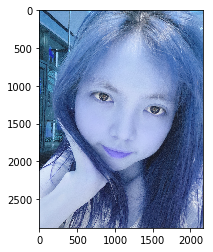

In [5]:
plt.imshow(img)
plt.show()
#cv2.imshow('Kim Anh', img)

In [6]:
ANNOT_PATH

'lisa/allAnnotations.csv'

In [7]:
# build the path to the output training and testing record files,
# along with the class labels file
TRAIN_RECORD = os.path.sep.join([BASE_PATH,
"records/training.record"])
TEST_RECORD = os.path.sep.join([BASE_PATH,
"records/testing.record"])
CLASSES_FILE = os.path.sep.join([BASE_PATH,
"records/classes.pbtxt"])

# initialize the test split size
TEST_SIZE = 0.25

# initialize the class labels dictionary
CLASSES = {"pedestrianCrossing": 1, "signalAhead": 2, "stop": 3}

In [8]:
# open the classes output file
f = open(config.CLASSES_FILE, "w")

# loop over the classes
for (k, v) in config.CLASSES.items():
# construct the class information and write to file
    item = ("item {\n"
    "\tid: " + str(v) + "\n"
    "\tname: '" + k + "'\n"
    "}\n")
    f.write(item)

# close the output classes file
f.close()

In [9]:
CLASSES_FILE

'lisa/records/classes.pbtxt'

In [10]:
D = {}
rows = open(config.ANNOT_PATH).read().strip().split("\n")

In [11]:
rows

['Filename;Annotation tag;Upper left corner X;Upper left corner Y;Lower right corner X;Lower right corner Y;Occluded,On another road;Origin file;Origin frame number;Origin track;Origin track frame number',
 'aiua120214-0/frameAnnotations-DataLog02142012_external_camera.avi_annotations/stop_1330545910.avi_image0.png;stop;862;104;916;158;0,0;aiua120214-0/DataLog02142012_external_camera.avi;2667;stop_1330545910.avi;2',
 'aiua120214-0/frameAnnotations-DataLog02142012_external_camera.avi_annotations/stop_1330545910.avi_image0.png;speedLimitUrdbl;425;197;438;213;0,0;aiua120214-0/DataLog02142012_external_camera.avi;2667;stop_1330545910.avi;2',
 'aiua120214-0/frameAnnotations-DataLog02142012_external_camera.avi_annotations/stop_1330545910.avi_image1.png;stop;922;88;982;148;1,0;aiua120214-0/DataLog02142012_external_camera.avi;2672;stop_1330545910.avi;7',
 'aiua120214-0/frameAnnotations-DataLog02142012_external_camera.avi_annotations/stop_1330545910.avi_image1.png;speedLimit25;447;193;461;210;0,

In [12]:
# loop over the individual rows, skipping the header
for row in rows[1:]:
    # break the row into components
    imb_bade_dir = "signDatabasePublicFramesOnly"
    row = row.split(",")[0].split(";")
    (imagePath, label, startX, startY, endX, endY, _) = row
    (startX, startY) = (float(startX), float(startY))
    (endX, endY) = (float(endX), float(endY))

    # if we are not interested in the label, ignore it
    if label not in config.CLASSES:
        continue
        
    # build the path to the input image, then grab any other
    # bounding boxes + labels associated with the image
    # path, labels, and bounding box lists, respectively
    p = os.path.sep.join([config.BASE_PATH, imb_bade_dir])
    p = os.path.sep.join([p, imagePath])
    b = D.get(p, []) # Could be 2 object in an image

    # build a tuple consisting of the label and bounding box,
    # then update the list and store it in the dictionary
    b.append((label, (startX, startY, endX, endY)))
    D[p] = b

In [13]:
len(D)

3288

In [14]:
# create training and testing splits from our data dictionary
(trainKeys, testKeys) = train_test_split(list(D.keys()),
test_size=config.TEST_SIZE, random_state=42)

# initialize the data split files
datasets = [
("train", trainKeys, config.TRAIN_RECORD),
("test", testKeys, config.TEST_RECORD)
]

In [15]:
len(trainKeys)

2466

In [18]:
# loop over the datasets
for (dType, keys, outputPath) in datasets:
    # initialize the TensorFlow writer and initialize the total
    # number of examples written to file
    print("[INFO] processing '{}'...".format(dType))
    writer = tf.python_io.TFRecordWriter(outputPath)
    total = 0

    # loop over all the keys in the current set
    for k in keys:
        # load the input image from disk as a TensorFlow object
        encoded = tf.gfile.GFile(k, "rb").read()
        encoded = bytes(encoded)

        # load the image from disk again, this time as a PIL
        # object
        pilImage = Image.open(k)
        (w, h) = pilImage.size[:2]

        # parse the filename and encoding from the input path
        filename = k.split(os.path.sep)[-1]
        encoding = filename[filename.rfind(".") + 1:]

        # initialize the annotation object used to store
        # information regarding the bounding box + labels
        tfAnnot = TFAnnotation()
        tfAnnot.image = encoded
        tfAnnot.encoding = encoding
        tfAnnot.filename = filename
        tfAnnot.width = w
        tfAnnot.height = h
        
        # loop over the bounding boxes + labels associated with
        # the image
        for (label, (startX, startY, endX, endY)) in D[k]:
            # TensorFlow assumes all bounding boxes are in the
            # range [0, 1] so we need to scale them
            xMin = startX / w
            xMax = endX / w
            yMin = startY / h
            yMax = endY / h

            # update the bounding boxes + labels lists
            tfAnnot.xMins.append(xMin)
            tfAnnot.xMaxs.append(xMax)
            tfAnnot.yMins.append(yMin)
            tfAnnot.yMaxs.append(yMax)
            tfAnnot.textLabels.append(label.encode("utf8"))
            tfAnnot.classes.append(config.CLASSES[label])
            tfAnnot.difficult.append(0)

            # increment the total number of examples
            total += 1
        
        # encode the data point attributes using the TensorFlow
        # helper functions
        features = tf.train.Features(feature=tfAnnot.build())
        example = tf.train.Example(features=features)

        # add the example to the writer
        writer.write(example.SerializeToString())
        
    # close the writer and print diagnostic information to the
    # user
    writer.close()
    print("[INFO] {} examples saved for '{}'".format(total, dType))

[INFO] processing 'train'...
[INFO] 2876 examples saved for 'train'
[INFO] processing 'test'...
[INFO] 955 examples saved for 'test'


import cv2
# Testing an image

# loop over the datasets
for (dType, keys, outputPath) in datasets:
    # initialize the TensorFlow writer and initialize the total
    # number of examples written to file
    total = 0

    # loop over all the keys in the current set
    for k in keys:
        # load the input image from disk as a TensorFlow object
        encoded = tf.gfile.GFile(k, "rb").read()
        encoded = bytes(encoded)

        # load the image from disk again, this time as a PIL
        # object
        pilImage = Image.open(k)
        (w, h) = pilImage.size[:2]

        # parse the filename and encoding from the input path
        filename = k.split(os.path.sep)[-1]
        encoding = filename[filename.rfind(".") + 1:]

        # initialize the annotation object used to store
        # information regarding the bounding box + labels
        tfAnnot = TFAnnotation()
        tfAnnot.image = encoded
        tfAnnot.encoding = encoding
        tfAnnot.filename = filename
        tfAnnot.width = w
        tfAnnot.height = h
        
        # loop over the bounding boxes + labels associated with
        # the image
        for (label, (startX, startY, endX, endY)) in D[k]:
            # TensorFlow assumes all bounding boxes are in the
            # range [0, 1] so we need to scale them
            xMin = startX / w
            xMax = endX / w
            yMin = startY / h
            yMax = endY / h
            
            
            # load the input image from disk and denormalize the
            # bounding box coordinates
            image = cv2.imread(k)
            startX = int(xMin * w)
            startY = int(yMin * h)
            endX = int(xMax * w)
            endY = int(yMax * h)
            
            
             # draw the bounding box on the image
            cv2.rectangle(image, (startX, startY), (endX, endY),
            (0, 255, 0), 2)
    
            # show the output image
            plt.imshow(image)
            plt.show()
            #cv2.imshow("Image", image)
            #cv2.waitKey(0)

            # increment the total number of examples
            total += 1
        
        
    # close the writer and print diagnostic information to the
    # user
    print("[INFO] {} examples saved for '{}'".format(total, dType))


